In [32]:
import pandas as pd
import xmltodict
import requests
import os

#### 앱스토어 리뷰 수집하기  
* mostrecent_df 변수: 가장 최근 순으로 정렬  
* mosthelpful_df 변수: 가장 도움이 되는 순으로 정렬  
* review_df 변수 : mostrecent_df + mosthelpful_df - (중복)

ThinQ: 993504342  
런드리고: 1453485913  


In [33]:
def get_url_index(url):
    response = requests.get(url).content.decode('utf8')
    xml = xmltodict.parse(response)

    last_url = [l['@href'] for l in xml['feed']['link'] if (l['@rel'] == 'last')][0]
    last_index = [int(s.replace('page=', '')) for s in last_url.split('/') if ('page=' in s)][0]

    return last_index

# https://stackoverflow.com/questions/1090282/api-to-monitor-iphone-app-store-reviews
def appstore_crawler(appid,sortmethod):
    url = 'https://itunes.apple.com/kr/rss/customerreviews/page=1/id=%i/sortby=%s/xml' % (appid, sortmethod)
    try:
        last_index = get_url_index(url)
    except Exception as e:
        print (url)
        print ('\tNo Reviews: appid %i' %appid)
        print ('\tException:', e)
        return

    result = list()
    for idx in range(1, last_index+1):
        url = "https://itunes.apple.com/kr/rss/customerreviews/page=%i/id=%i/sortby=%s/xml?urlDesc=/customerreviews/id=%i/sortBy=%s/xml" % (idx, appid, sortmethod, appid, sortmethod)
        print(url)

        response = requests.get(url).content.decode('utf8')
        try:
            xml = xmltodict.parse(response)
        except Exception as e:
            print ('\tXml Parse Error %s\n\tSkip %s :' %(e, url))
            continue

        try:
            num_reivews= len(xml['feed']['entry'])
        except Exception as e:
            print ('\tNo Entry', e)
            continue

        try:
            xml['feed']['entry'][0]['author']['name']
            single_reviews = False
        except:
            #print ('\tOnly 1 review!!!')
            single_reviews = True
            pass

        if single_reviews:
                result.append({
                    'userName': xml['feed']['entry']['author']['name'],
                    'date': xml['feed']['entry']['updated'],
                    'rating': int(xml['feed']['entry']['im:rating']),
                    'like': int(xml['feed']['entry']['im:voteSum']),
                    'title': xml['feed']['entry']['title'],
                    'review': xml['feed']['entry']['content'][0]['#text'],
                })
        else:
            for i in range(len(xml['feed']['entry'])):
                result.append({
                    'userName': xml['feed']['entry'][i]['author']['name'],
                    'date': xml['feed']['entry'][i]['updated'],
                    'rating': int(xml['feed']['entry'][i]['im:rating']),
                    'like': int(xml['feed']['entry'][i]['im:voteSum']),
                    'title': xml['feed']['entry'][i]['title'],
                    'review': xml['feed']['entry'][i]['content'][0]['#text'],
                })

    res_df = pd.DataFrame(result)
    res_df['date'] = pd.to_datetime(res_df['date'], format="%Y-%m-%dT%H:%M:%S")
#     res_df.to_csv(outfile, encoding='utf-8-sig', index=False)
#     print ('Save reviews to file: %s \n' %(outfile))
    return res_df


if __name__ == '__main__':
    app_id = 1453485913
    mostrecent_df = appstore_crawler(app_id, 'mostrecent')
    mosthelpful_df = appstore_crawler(app_id, 'mosthelpful')
    
    # 병합
    review_df = pd.concat([mostrecent_df, mosthelpful_df])
    review_df.drop_duplicates(keep="first",inplace=True)
    review_df['content'] = review_df['title'] + ' ' + review_df['review']

https://itunes.apple.com/kr/rss/customerreviews/page=1/id=1453485913/sortby=mostrecent/xml?urlDesc=/customerreviews/id=1453485913/sortBy=mostrecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=2/id=1453485913/sortby=mostrecent/xml?urlDesc=/customerreviews/id=1453485913/sortBy=mostrecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=3/id=1453485913/sortby=mostrecent/xml?urlDesc=/customerreviews/id=1453485913/sortBy=mostrecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=4/id=1453485913/sortby=mostrecent/xml?urlDesc=/customerreviews/id=1453485913/sortBy=mostrecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=5/id=1453485913/sortby=mostrecent/xml?urlDesc=/customerreviews/id=1453485913/sortBy=mostrecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=6/id=1453485913/sortby=mostrecent/xml?urlDesc=/customerreviews/id=1453485913/sortBy=mostrecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=7/id=1453485913/sortby=mostrecent/x

In [34]:
# 파일 저장
review_df.to_csv("./crawling_data/apple_lundrygo_original.csv",encoding='utf-8 sig', index=False)

---------------------------------

In [15]:
# 파일 불러오기
review_df = pd.read_csv("./crawling_data/apple_lundrygo_original.csv", encoding='utf-8 sig')
review_df

,userName,date,rating,like,title,review,content
0,강남오렌지,2022-07-24 20:24:44-07:00,1,0,스마트케어 온도 설정,"기준 온도 직접 설정 27도로 설정해놨는데, 자꾸 희망온도가 28도로 올라감...하..","스마트케어 온도 설정 기준 온도 직접 설정 27도로 설정해놨는데, 자꾸 희망온도가 ..."
1,우주괴에물,2022-07-24 08:08:11-07:00,1,0,TV 연결 안됨,유튜브나 넷플릭스에서는 같은 네트워크일 때 연결하겠습니까 잘 뜨는데 씽큐에서 제품연...,TV 연결 안됨 유튜브나 넷플릭스에서는 같은 네트워크일 때 연결하겠습니까 잘 뜨는데...
2,ㅇ헣ㄹㅇ,2022-07-24 05:57:38-07:00,5,0,굿,엘지 iot 시작,굿 엘지 iot 시작
3,까암씨,2022-07-23 22:59:15-07:00,5,0,건조기 등록이 너무 어려워 별 4 개요,건조기 등록이 너무 잘안되용. 그래서 4 개 입니다.,건조기 등록이 너무 어려워 별 4 개요 건조기 등록이 너무 잘안되용. 그래서 4 개...
4,라이프이즈구웃,2022-07-23 07:35:17-07:00,4,0,백색가전은 엘지,앱으로 가전 제품 관리하기가 용이해요,백색가전은 엘지 앱으로 가전 제품 관리하기가 용이해요
...,...,...,...,...,...,...,...
913,ㅎㅎㅋㅋㅎㅎㄹㅋㄱㅁ,2019-06-22 04:15:25-07:00,3,0,우와 했는데,오늘 에어컨 설치하고 어플받고 제품등록 싹하고 기존에 있던 공기청정기 등록 다하고 ...,우와 했는데 오늘 에어컨 설치하고 어플받고 제품등록 싹하고 기존에 있던 공기청정기 ...
914,샤레레마,2018-04-26 16:36:23-07:00,5,0,관리를 안하는건가요?,원격제품은 팔아놓으시고 서비스관리는 안하시는 건가요? 저번에도 그랬는데 어제부터 서...,관리를 안하는건가요? 원격제품은 팔아놓으시고 서비스관리는 안하시는 건가요? 저번에도...
915,Myoyu,2021-08-28 16:29:22-07:00,2,0,업데이트후 제습기 예약 동작 오류,"매일, 일정시간에 켜고 일정시간후 끄기 예약 기능 잘 사용하고 있었는데 업데이트후 ...","업데이트후 제습기 예약 동작 오류 매일, 일정시간에 켜고 일정시간후 끄기 예약 기능..."
916,초등학생,2021-08-22 00:19:29-07:00,3,0,에어컨 네트워크 보안 WPA3 지원요청,에어컨 네트워크 보안 WAP3 지원 요청합니다.\n\n현재는 지원을 안해서 WPA/...,에어컨 네트워크 보안 WPA3 지원요청 에어컨 네트워크 보안 WAP3 지원 요청합니...


####  데이터 전처리  
- 문장 자르기
- 맞춤법 검사  
- 품사 분류  
- 불용어 처리  

In [35]:
# 문자 빼고 지움(정규표현식)
# 문장 자르기
import kss
import re

UNKNOWN_WORD = "...하"
def OnlyWords(s):
    result = re.sub('[^ A-Za-z가-힣]', '', s)
    return result

review_df['content_n']=review_df['content'].apply(\
        lambda x: kss.split_sentences(OnlyWords(x)) if UNKNOWN_WORD not in x else kss.split_sentences(OnlyWords(x).replace(UNKNOWN_WORD,"..")))

In [37]:
# 맞춤법 검사 
from hanspell import spell_checker

def spell_checking(sent_list):
    sent_spell=[]
    for sentence in sent_list:
        sent_spell.append(spell_checker.check(sentence).checked)
    return(sent_spell)

review_df['cotent_n_spell']=review_df['content_n'].apply(lambda x: spell_checking(x))

In [38]:
review_df['content_n']=review_df['cotent_n_spell']

In [41]:
# 중간 저장
review_df.to_csv("./crawling_data/apple_lundrygo_preprocessing1.csv", encoding='utf-8 sig', index=False)

In [93]:
# 파일 불러오기
review_df = pd.read_csv("./crawling_data/apple_lundrygo_preprocessing1.csv", encoding='utf-8 sig')

In [94]:
review_df

,userName,date,rating,like,title,review,content,content_n,cotent_n_spell
0,어린왕자와여우,2022-07-25 08:45:47-07:00,1,0,초심 잃고 점점 품질 저하 되는 중,일단 배송 기한 제대로 못 맞추고 구구절절 핑계 가득한 문자 보내면서 결국 늦게 배...,초심 잃고 점점 품질 저하 되는 중 일단 배송 기한 제대로 못 맞추고 구구절절 핑계...,['초심 잃고 점점 품질 저하되는 중 일단 배송 기한 제대로 못 맞추고 구구절절 핑...,['초심 잃고 점점 품질 저하되는 중 일단 배송 기한 제대로 못 맞추고 구구절절 핑...
1,plzlogin,2022-07-25 07:46:07-07:00,5,0,너무 편리해요,일땜에 호텔에서 한달 숙박하는데 호텔 코인세탁기가 너무 더럽고 냄새나서 이용하게 됐...,너무 편리해요 일땜에 호텔에서 한달 숙박하는데 호텔 코인세탁기가 너무 더럽고 냄새나...,"['너무 편리해요', '일 땜에 호텔에서 한 달 숙박하는데 호텔 코인세탁기가 너무 ...","['너무 편리해요', '일 땜에 호텔에서 한 달 숙박하는데 호텔 코인세탁기가 너무 ..."
2,슐ㄹ,2022-07-25 06:19:29-07:00,5,0,편리한 앱,앱 사용도 간단하고 편리하게 사용할 수 있어서 좋아요!,편리한 앱 앱 사용도 간단하고 편리하게 사용할 수 있어서 좋아요!,['편리한 앱 앱 사용도 간단하고 편리하게 사용할 수 있어서 좋아요'],['편리한 앱 앱 사용도 간단하고 편리하게 사용할 수 있어서 좋아요']
3,감자간즈,2022-07-25 04:21:56-07:00,5,0,편리하고 좋습니다,요즘 여름이라 비도 많이 오고 빨래감이 많아서 수건 돌리면 옷 돌릴 시간이 없었는데...,편리하고 좋습니다 요즘 여름이라 비도 많이 오고 빨래감이 많아서 수건 돌리면 옷 돌...,"['편리하고 좋습니다', '요즘 여름이라 비도 많이 오고 빨랫감이 많아서 수건 돌리...","['편리하고 좋습니다', '요즘 여름이라 비도 많이 오고 빨랫감이 많아서 수건 돌리..."
4,Zhsksosjxjejdido,2022-07-25 01:55:00-07:00,5,0,앱 너무 좋아요,주말에도 수거가 되고 수선도 되고 앞으로 자주 이용할것같아요,앱 너무 좋아요 주말에도 수거가 되고 수선도 되고 앞으로 자주 이용할것같아요,"['앱 너무 좋아요', '주말에도 수거가 되고 수선도 되고 앞으로 자주 이용할 것 ...","['앱 너무 좋아요', '주말에도 수거가 되고 수선도 되고 앞으로 자주 이용할 것 ..."
...,...,...,...,...,...,...,...,...,...
892,HYUNJINJE,2022-05-31 02:32:45-07:00,5,0,너무 편리해요,집 근처에 세탁소가 없어서 매번 맡기러가고 찾으러가고 힘들었는데 집앞에서 해결되니 ...,너무 편리해요 집 근처에 세탁소가 없어서 매번 맡기러가고 찾으러가고 힘들었는데 집앞...,"['너무 편리해요', '집 근처에 세탁소가 없어서 매번 맡기러 가고 찾으러 가고 힘...","['너무 편리해요', '집 근처에 세탁소가 없어서 매번 맡기러 가고 찾으러 가고 힘..."
893,티찰라범블비,2021-11-06 05:50:45-07:00,5,0,진짜 좋아요,"별생각 없이 신청했었는데 세탁 전 사진 보내주시는 점, 혹시라도 지워지지 않는 얼룩...","진짜 좋아요 별생각 없이 신청했었는데 세탁 전 사진 보내주시는 점, 혹시라도 지워지...","['진짜 좋아요', '별생각 없이 신청했었는데 세탁 전 사진 보내주시는 점 혹시라도...","['진짜 좋아요', '별생각 없이 신청했었는데 세탁 전 사진 보내주시는 점 혹시라도..."
894,룰루룰룽,2021-12-20 17:36:46-07:00,1,2,옷 손상도 많고 고객센터는 응대에 한달씩 걸림,첨에 배송은 만족했는데 옷에 손상도 많고 특히 손상 이후에 피드백이 너무 늦습니다....,옷 손상도 많고 고객센터는 응대에 한달씩 걸림 첨에 배송은 만족했는데 옷에 손상도 ...,"['옷 손상도 많고 고객센터는 응대에 한 달씩 걸림', '첨에 배송은 만족했는데 옷...","['옷 손상도 많고 고객센터는 응대에 한 달씩 걸림', '첨에 배송은 만족했는데 옷..."
895,jungke109,2021-10-12 02:07:17-07:00,4,0,이미 1년째 사용 중,1. 빨래로부터 해방되어서 너무 행복 2. 빨래 실패가 없음 (냄새나거나 물들거나)...,이미 1년째 사용 중 1. 빨래로부터 해방되어서 너무 행복 2. 빨래 실패가 없음 ...,"['이미 년째 사용 중 빨래로부터 해방되어서 너무 행복 빨래 실패가 없음', '냄새...","['이미 년째 사용 중 빨래로부터 해방되어서 너무 행복 빨래 실패가 없음', '냄새..."


In [85]:
#  string to list

import ast
review_df['content_n'] = review_df['content_n'].apply(lambda x: ast.literal_eval(x))

In [86]:
from konlpy.tag import Okt  
okt=Okt() 
# 명사, 형용사, 동사
def n_a_v_selection(sent_list):
    sent_tokens=[]
    for sentence in sent_list:
        pos_result=okt.pos(sentence, stem=True)
        filtered_result=[pair[0] for pair in pos_result if (pair[1]=='Alpha')or(pair[1]=='Noun')or(pair[1]=='Verb')or(pair[1]=='Adjective') or(pair[1]=='Adverb')]
        sent_tokens.append(filtered_result)
    return sent_tokens

# 명사, 형용사
def n_a_selection(sent_list):
    sent_tokens=[]
    for sentence in sent_list:
        pos_result=okt.pos(sentence, stem=True)
        filtered_result=[pair[0] for pair in pos_result if (pair[1]=='Alpha')or(pair[1]=='Noun')or(pair[1]=='Adjective') or(pair[1]=='Adverb')]
        sent_tokens.append(filtered_result)
    return sent_tokens
        
# 명사만
def noun_selection(sent_list):
    sent_tokens=[]
    for sentence in sent_list:
        sent_tokens.append(okt.nouns(sentence))
    return(sent_tokens)


review_df['content_n']=review_df['content_n'].apply(lambda x: n_a_selection(x))

In [87]:
# 불용어 처리
import json

with open('korean_stopword.json',encoding='utf8') as f:
    stopwords = json.load(f)

stopwords.extend(['안','수','거','왜','것','후','에서','고','이다','는','한','안녕','형','형님','건','안','요','거','피','질','번','용','군','영','스','좀','데','듯','넉','테','런','하다','하나요','되다','안되다','있다','없다'])

def rem_n_stopwords(sent_list):
    sent_stop=[]
    for sentence in sent_list:
        new_sent=[]
        for token in sentence:
            if token not in stopwords:
                new_sent.append(token)
        sent_stop.append(new_sent)
    return(sent_stop)

review_df['content_n']=review_df['content_n'].apply(lambda x: rem_n_stopwords(x))

In [89]:
# 빈 리스트 제거
def remove_empty_list(sent_list):
    removed_list = []
    for sentence in sent_list:
        if sentence: # sentence가 빈 경우가 아니면
            removed_list.append(sentence)    
    return removed_list

review_df['content_n']=review_df['content_n'].apply(lambda x: remove_empty_list(x))

# review_df.to_csv('thinq_review_result.csv',index=False, encoding='utf-8-sig')

# 리뷰 전체를 한 리스트로 만들기
def one_word_list(sent_list):
    one_list=[]
    for sentence in sent_list:
        one_list.extend(sentence)
    return(one_list)

# test['content_n']=test['content_n'].apply(lambda x: one_word_list(x))
review_df['content_n']=review_df['content_n'].apply(lambda x: one_word_list(x))

In [91]:
review_df

,userName,date,rating,like,title,review,content,content_n,cotent_n_spell
0,어린왕자와여우,2022-07-25 08:45:47-07:00,1,0,초심 잃고 점점 품질 저하 되는 중,일단 배송 기한 제대로 못 맞추고 구구절절 핑계 가득한 문자 보내면서 결국 늦게 배...,초심 잃고 점점 품질 저하 되는 중 일단 배송 기한 제대로 못 맞추고 구구절절 핑계...,"[초, 심, 점, 점, 품, 질, 저, 하, 중, 배, 송, 기, 한, 제, 대, ...",['초심 잃고 점점 품질 저하되는 중 일단 배송 기한 제대로 못 맞추고 구구절절 핑...
1,plzlogin,2022-07-25 07:46:07-07:00,5,0,너무 편리해요,일땜에 호텔에서 한달 숙박하는데 호텔 코인세탁기가 너무 더럽고 냄새나서 이용하게 됐...,너무 편리해요 일땜에 호텔에서 한달 숙박하는데 호텔 코인세탁기가 너무 더럽고 냄새나...,"[너, 무, 편, 리, 하, 다, 땜, 호, 텔, 달, 숙, 박, 호, 텔, 코, ...","['너무 편리해요', '일 땜에 호텔에서 한 달 숙박하는데 호텔 코인세탁기가 너무 ..."
2,슐ㄹ,2022-07-25 06:19:29-07:00,5,0,편리한 앱,앱 사용도 간단하고 편리하게 사용할 수 있어서 좋아요!,편리한 앱 앱 사용도 간단하고 편리하게 사용할 수 있어서 좋아요!,"[편, 리, 하, 다, 앱, 앱, 사, 용, 간, 단, 하, 다, 편, 리, 하, ...",['편리한 앱 앱 사용도 간단하고 편리하게 사용할 수 있어서 좋아요']
3,감자간즈,2022-07-25 04:21:56-07:00,5,0,편리하고 좋습니다,요즘 여름이라 비도 많이 오고 빨래감이 많아서 수건 돌리면 옷 돌릴 시간이 없었는데...,편리하고 좋습니다 요즘 여름이라 비도 많이 오고 빨래감이 많아서 수건 돌리면 옷 돌...,"[편, 리, 하, 다, 좋, 다, 요, 즘, 여, 름, 비, 도, 많, 이, 빨, ...","['편리하고 좋습니다', '요즘 여름이라 비도 많이 오고 빨랫감이 많아서 수건 돌리..."
4,Zhsksosjxjejdido,2022-07-25 01:55:00-07:00,5,0,앱 너무 좋아요,주말에도 수거가 되고 수선도 되고 앞으로 자주 이용할것같아요,앱 너무 좋아요 주말에도 수거가 되고 수선도 되고 앞으로 자주 이용할것같아요,"[앱, 너, 무, 좋, 다, 주, 말, 수, 거, 수, 선, 앞, 자, 주, 이, 용]","['앱 너무 좋아요', '주말에도 수거가 되고 수선도 되고 앞으로 자주 이용할 것 ..."
...,...,...,...,...,...,...,...,...,...
892,HYUNJINJE,2022-05-31 02:32:45-07:00,5,0,너무 편리해요,집 근처에 세탁소가 없어서 매번 맡기러가고 찾으러가고 힘들었는데 집앞에서 해결되니 ...,너무 편리해요 집 근처에 세탁소가 없어서 매번 맡기러가고 찾으러가고 힘들었는데 집앞...,"[너, 무, 편, 리, 하, 다, 집, 근, 처, 세, 탁, 소, 힘, 들, 다, ...","['너무 편리해요', '집 근처에 세탁소가 없어서 매번 맡기러 가고 찾으러 가고 힘..."
893,티찰라범블비,2021-11-06 05:50:45-07:00,5,0,진짜 좋아요,"별생각 없이 신청했었는데 세탁 전 사진 보내주시는 점, 혹시라도 지워지지 않는 얼룩...","진짜 좋아요 별생각 없이 신청했었는데 세탁 전 사진 보내주시는 점, 혹시라도 지워지...","[진, 짜, 좋, 다, 생, 각, 없, 이, 신, 청, 세, 탁, 전, 사, 진, ...","['진짜 좋아요', '별생각 없이 신청했었는데 세탁 전 사진 보내주시는 점 혹시라도..."
894,룰루룰룽,2021-12-20 17:36:46-07:00,1,2,옷 손상도 많고 고객센터는 응대에 한달씩 걸림,첨에 배송은 만족했는데 옷에 손상도 많고 특히 손상 이후에 피드백이 너무 늦습니다....,옷 손상도 많고 고객센터는 응대에 한달씩 걸림 첨에 배송은 만족했는데 옷에 손상도 ...,"[옷, 손, 상, 많, 다, 고, 객, 센, 터, 응, 대, 달, 첨, 배, 송, ...","['옷 손상도 많고 고객센터는 응대에 한 달씩 걸림', '첨에 배송은 만족했는데 옷..."
895,jungke109,2021-10-12 02:07:17-07:00,4,0,이미 1년째 사용 중,1. 빨래로부터 해방되어서 너무 행복 2. 빨래 실패가 없음 (냄새나거나 물들거나)...,이미 1년째 사용 중 1. 빨래로부터 해방되어서 너무 행복 2. 빨래 실패가 없음 ...,"[이, 미, 사, 용, 중, 빨, 래, 해, 방, 너, 무, 행, 복, 빨, 래, ...","['이미 년째 사용 중 빨래로부터 해방되어서 너무 행복 빨래 실패가 없음', '냄새..."


In [81]:
# 전처리 完
review_df.to_csv("./crawling_data/apple_lundrygo_na_processing2.csv", encoding='utf-8 sig', index=False)

In [62]:
# 단어 빈도 그래프
total_word=[]
for i in range(len(review_df)):
    total_word.extend(review_df.loc[i,'content_n'])

word_vc = pd.Series(total_word).value_counts()

In [63]:
word_vc

좋다     774
너무     692
세탁     637
런드리    596
이용     503
      ... 
예민       1
돌        1
구의       1
급        1
엄태성      1
Length: 3106, dtype: int64

#### (4) 워드클라우드  
- 워드클라우드 만들고 이미지 저장

In [3]:
# 프로그램 재실행할 경우, 파일 읽기
review_df = pd.read_csv("./crawling_data/apple_lundrygo_processing2.csv", encoding='utf-8 sig')

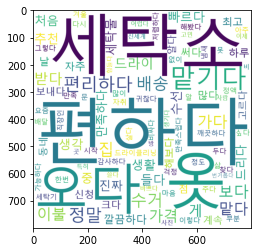

In [71]:
# 워드클라우드
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_dict = word_vc.to_dict()
delete_word = ['앱','더','개','해주다','좋다','사용','자다','않다','너무','아니다','돼다','쓰다','다','어플','런드리','이용','앞','되어다','세탁','빨래','서비스']
for word in delete_word:
    del word_dict[word]

wc = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf', 
               width=400, height=400,scale=2,
               max_font_size=250, max_words=100,
               background_color='white')
gen = wc.generate_from_frequencies(word_dict)
plt.figure()
plt.imshow(gen)
plt.savefig("./crawling_data/apple_lundrygo_nav_wordcloud.png", dpi=300)

In [72]:
# 이미지 저장
review_df

,userName,date,rating,like,title,review,content,content_n,cotent_n_spell
0,어린왕자와여우,2022-07-25 08:45:47-07:00,1,0,초심 잃고 점점 품질 저하 되는 중,일단 배송 기한 제대로 못 맞추고 구구절절 핑계 가득한 문자 보내면서 결국 늦게 배...,초심 잃고 점점 품질 저하 되는 중 일단 배송 기한 제대로 못 맞추고 구구절절 핑계...,"[초심, 잃다, 점점, 품질, 저하, 중, 배송, 기한, 제대로, 못, 맞추다, 절...",['초심 잃고 점점 품질 저하되는 중 일단 배송 기한 제대로 못 맞추고 구구절절 핑...
1,plzlogin,2022-07-25 07:46:07-07:00,5,0,너무 편리해요,일땜에 호텔에서 한달 숙박하는데 호텔 코인세탁기가 너무 더럽고 냄새나서 이용하게 됐...,너무 편리해요 일땜에 호텔에서 한달 숙박하는데 호텔 코인세탁기가 너무 더럽고 냄새나...,"[너무, 편리하다, 땜, 호텔, 달, 숙박, 호텔, 코인, 세탁기, 너무, 더럽다,...","['너무 편리해요', '일 땜에 호텔에서 한 달 숙박하는데 호텔 코인세탁기가 너무 ..."
2,슐ㄹ,2022-07-25 06:19:29-07:00,5,0,편리한 앱,앱 사용도 간단하고 편리하게 사용할 수 있어서 좋아요!,편리한 앱 앱 사용도 간단하고 편리하게 사용할 수 있어서 좋아요!,"[편리하다, 앱, 앱, 사용, 간단하다, 편리하다, 사용, 좋다]",['편리한 앱 앱 사용도 간단하고 편리하게 사용할 수 있어서 좋아요']
3,감자간즈,2022-07-25 04:21:56-07:00,5,0,편리하고 좋습니다,요즘 여름이라 비도 많이 오고 빨래감이 많아서 수건 돌리면 옷 돌릴 시간이 없었는데...,편리하고 좋습니다 요즘 여름이라 비도 많이 오고 빨래감이 많아서 수건 돌리면 옷 돌...,"[편리하다, 좋다, 요즘, 여름, 비도, 많이, 오다, 빨랫감, 많다, 수건, 돌리...","['편리하고 좋습니다', '요즘 여름이라 비도 많이 오고 빨랫감이 많아서 수건 돌리..."
4,Zhsksosjxjejdido,2022-07-25 01:55:00-07:00,5,0,앱 너무 좋아요,주말에도 수거가 되고 수선도 되고 앞으로 자주 이용할것같아요,앱 너무 좋아요 주말에도 수거가 되고 수선도 되고 앞으로 자주 이용할것같아요,"[앱, 너무, 좋다, 주말, 수거, 수선, 앞, 자주, 이용]","['앱 너무 좋아요', '주말에도 수거가 되고 수선도 되고 앞으로 자주 이용할 것 ..."
...,...,...,...,...,...,...,...,...,...
892,HYUNJINJE,2022-05-31 02:32:45-07:00,5,0,너무 편리해요,집 근처에 세탁소가 없어서 매번 맡기러가고 찾으러가고 힘들었는데 집앞에서 해결되니 ...,너무 편리해요 집 근처에 세탁소가 없어서 매번 맡기러가고 찾으러가고 힘들었는데 집앞...,"[너무, 편리하다, 집, 근처, 세탁소, 맡다, 가다, 찾다, 가다, 힘들다, 집,...","['너무 편리해요', '집 근처에 세탁소가 없어서 매번 맡기러 가고 찾으러 가고 힘..."
893,티찰라범블비,2021-11-06 05:50:45-07:00,5,0,진짜 좋아요,"별생각 없이 신청했었는데 세탁 전 사진 보내주시는 점, 혹시라도 지워지지 않는 얼룩...","진짜 좋아요 별생각 없이 신청했었는데 세탁 전 사진 보내주시는 점, 혹시라도 지워지...","[진짜, 좋다, 생각, 없이, 신청, 세탁, 전, 사진, 보내다, 점, 지워지다, ...","['진짜 좋아요', '별생각 없이 신청했었는데 세탁 전 사진 보내주시는 점 혹시라도..."
894,룰루룰룽,2021-12-20 17:36:46-07:00,1,2,옷 손상도 많고 고객센터는 응대에 한달씩 걸림,첨에 배송은 만족했는데 옷에 손상도 많고 특히 손상 이후에 피드백이 너무 늦습니다....,옷 손상도 많고 고객센터는 응대에 한달씩 걸림 첨에 배송은 만족했는데 옷에 손상도 ...,"[옷, 손상, 많다, 고객, 센터, 응대, 달, 걸리다, 첨, 배송, 만족하다, 옷...","['옷 손상도 많고 고객센터는 응대에 한 달씩 걸림', '첨에 배송은 만족했는데 옷..."
895,jungke109,2021-10-12 02:07:17-07:00,4,0,이미 1년째 사용 중,1. 빨래로부터 해방되어서 너무 행복 2. 빨래 실패가 없음 (냄새나거나 물들거나)...,이미 1년째 사용 중 1. 빨래로부터 해방되어서 너무 행복 2. 빨래 실패가 없음 ...,"[이미, 사용, 중, 빨래, 해방, 되어다, 너무, 행복, 빨래, 실패, 냄새, 거...","['이미 년째 사용 중 빨래로부터 해방되어서 너무 행복 빨래 실패가 없음', '냄새..."
